Se pretende determinar el precio a ofertar a un contrato del sector público en función del precio de licitación en los procedimeintos abierto y abierto simplificado.

Se utilizara los datos de contratos publicados en la Plataforma de contratción del Estado del ejercicio 2021.
https://contrataciondelestado.es/wps/portal/plataforma

Bibliografia y documentación apoyo:
Notebooks aportado por The Bridge( Rafael Zambrano, Jonhatan, )
Hands on machine learning with Scikit-Learn, keras and TensorFlow.- Aurelien Géron. Ed O'Reilly
Redes neuronales con Python by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/py35-redes-neuronales-python.html

https://Stackoverflow.com



In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Modelado
# ==============================================================================
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


C:\Users\ragod\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ragod\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ragod\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Descarga de datos
# ==============================================================================
df_lici1   = pd.read_excel(r'C:\Users\ragod\Desktop\Contratos2\2021.xlsx', sheet_name='Licitaciones')
df_result1 = pd.read_excel(r'C:\Users\ragod\Desktop\Contratos2\2021.xlsx', sheet_name='Resultados')

# Se renombran las columnas para que sean más descriptivas/cortas
nuevas_col_lici =['identificador','link','fecha',
       'vigencia',
       'precio_lici',
       'cpv',
       'tipo_cont',
       'org_cont',
       'tipo_admi',
        'tipo_pro',
        'sist_cont',
        'subcontratacion']
nuevas_col_result =['identificador', 'link','fecha','resultado',
       'precio_min',
       'precio_max',
       'baja_tem',
       'precio_adj_sin_imp',
       'precio_adj_con_imp']

df_lici1=df_lici1.rename(columns={k:v for k,v in zip(df_lici1.columns, nuevas_col_lici)})
df_result1=df_result1.rename(columns={k:v for k,v in zip(df_result1.columns, nuevas_col_result)})

In [3]:
# Tipo de cada columna
# ==============================================================================

df_lici1.info()
df_result1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145470 entries, 0 to 145469
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   identificador    145470 non-null  int64         
 1   link             145470 non-null  object        
 2   fecha            145470 non-null  datetime64[ns]
 3   vigencia         145470 non-null  object        
 4   precio_lici      144780 non-null  float64       
 5   cpv              144131 non-null  object        
 6   tipo_cont        145470 non-null  object        
 7   org_cont         145470 non-null  object        
 8   tipo_admi        145470 non-null  object        
 9   tipo_pro         145470 non-null  object        
 10  sist_cont        141855 non-null  object        
 11  subcontratacion  20249 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 13.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1

In [4]:
#Limpieza básica
#=======================================================
#Eliminacion columnas por no ser significativas
df_lici1.drop(['link','fecha','vigencia','org_cont','tipo_admi','subcontratacion'],axis = 1,inplace = True)
df_result1.drop(['link','fecha'],axis = 1,inplace = True)

In [5]:
# Modificaciones de df_lici_1
df_lici2 = df_lici1
df_lici2.identificador = df_lici2.identificador.astype('string')

#Modifciaciones de df_resutl1
df_result2 = df_result1
df_result2.identificador = df_result2.identificador.astype('string')
df_result2 = df_result2.fillna(0)

In [6]:
# Seleccion solo de los adjudicados.
#=====================================================================
#Aquellos que tienen un lote no adjudicado se eliminan todos por no tener detalle de licitacion
#identificacion no adjudicados en resultados
lista_no_adjudica = df_result2.identificador[df_result2.resultado != 'Adjudicado']
lista_no_adjudica_result_index = df_result2[df_result2.identificador.isin(lista_no_adjudica)].index

#deteccion de no adjuidcados en liccitaciones
lista_no_adjudicados=list(lista_no_adjudica.unique())
lista_no_adjudica_lici_index = df_lici2[df_lici2.identificador.isin(lista_no_adjudicados)].index

#Deteccion de adjudicados
licitaciones_adjudicadas_index=[i for i in df_lici2.index if i not in lista_no_adjudica_lici_index]
resultados_adjudicados_index=[i for i in df_result2.index if i not in lista_no_adjudica_result_index]

In [7]:
# Eliminacion de no ejecutados
df_lici3 = df_lici2.iloc[licitaciones_adjudicadas_index].reset_index(drop=True)
df_result3   = df_result2.iloc[resultados_adjudicados_index].reset_index(drop=True)


In [8]:
# Elimino aquellos adjudicados con precio de adjudicacion 0

df_result3 = df_result3[df_result3.precio_adj_sin_imp != 0]

In [9]:
# Agrupacion de resultados por identificador

df_result4 = df_result3.groupby('identificador',as_index = False).sum()


In [10]:
#Asignacion de valors max y min cuando son 0.
df_result4.loc[(df_result4.precio_min==0)&(df_result4.precio_max==0),['precio_min','precio_max']]=df_result4['precio_adj_sin_imp']

In [11]:
#Selección de licitaciones aquellas que tienen adjudicaciones
#==============================================================
identificador_result = list(df_result4.identificador)
df_lici3[df_lici3['identificador'].isin ( df_result4.identificador)]

,identificador,precio_lici,cpv,tipo_cont,tipo_pro,sist_cont
0,1001606,910892.00,34933000;,Suministros,Negociado con publicidad,NaN
1,1002267,240000.00,98351000;,Gestión de Servicios Públicos,Abierto,NaN
2,1007145,2472400.00,32524000;,Suministros,Negociado con publicidad,NaN
3,1007418,3720000.00,90910000;,Servicios,Abierto,NaN
4,1007814,261584.00,98341130;,Servicios,Normas internas,No aplica
...,...,...,...,...,...,...
134190,985152,1322880.00,60160000;,Servicios,Negociado con publicidad,NaN
134191,985194,27239507.00,45234110;,Obras,Abierto,NaN
134192,991030,1383385.39,45331000;,Obras,Negociado con publicidad,No aplica
134194,996489,554040.00,50413200;,Servicios,Abierto,NaN


In [12]:
#Creacion de set único
#==============================================
df_final=df_lici3.join(df_result4.set_index('identificador'), on ='identificador', how = 'right')

In [13]:
#Limpieza de set unico
#=========================================================================
# elimino licitaciones sin precio
df_final2=df_final[df_final.precio_lici.isnull()== False]

#elimino licitaciones menores que el adjudicado

df_final2 = df_final2[(df_final2.precio_lici < df_final2.precio_adj_sin_imp) == False]

#elimino licitaciones con importe 0

df_final2 = df_final2[df_final2.precio_lici > 5000]

# elimino las licitaciones con cpv nulo

df_final2=df_final2[df_final2.cpv.isnull()== False]


In [14]:
#Estudio de variables.- Tipo de procedimiento tipo_pro
#==============================================================
df_final2.groupby('tipo_pro').count()

#Se mantienen solo Abierto y Abierto simplificado. Son los procedieminetos donde predomina critero precio.
df_final3 =df_final2[(df_final2.tipo_pro=='Abierto')|(df_final2.tipo_pro =='Abierto simplificado')]

In [33]:
#Estudio de variables.- Tipo de contrato tipo_cont
#==============================================================
df_final3.groupby('tipo_cont').count()

# Seleccionamos los tipos de contratos más comunes: Obras, Suministros y Servicios

df_final4 = df_final3[(df_final3.tipo_cont =='Obras')|(df_final3.tipo_cont =='Suministros')|(df_final3.tipo_cont =='Servicios')].reset_index(drop=True)

In [34]:
#Eliminacion de columnas que se desconce su valor antes de la adjudicación y redundante
#cpv, sist_cont,precio_min, precio_max, precio_adj_con_imp

df_final5=df_final4[['identificador','precio_lici', 'precio_adj_sin_imp','tipo_cont','tipo_pro']]

In [35]:
#Descripcion del set final
df_final5.describe().style.format(precision=2)

,precio_lici,precio_adj_sin_imp
count,68392.00,68392.00
mean,831185.96,454379.02
std,10053673.23,6966097.02
min,5000.35,0.01
25%,41322.31,24000.00
50%,93219.32,58350.37
75%,261295.49,162612.25
max,1584728506.91,1487654353.47


In [36]:
#Eliminacion de licitación con importes muy altos
# Se consideran anomalas las licitaciones superiores a 50.000.000

df_final5=df_final5.drop(df_final5[df_final5['precio_lici']>50000000].index)
df_final5 =df_final5.reset_index(drop=True)

In [37]:
#Outliers
#==========================================================
stats=df_final5.describe().T

stats['IQR']=stats['75%'] - stats['25%']

stats.style.format(precision =2)

outliers=pd.DataFrame(columns=df_final5.columns)
for e in stats.index:
    
    iqr=stats.at[e, 'IQR']
    
    cutoff=1.5*iqr
    
    lower=stats.at[e, '25%']-cutoff
    upper=stats.at[e, '75%']+cutoff
    
    results=df_final5[(df_final5[e]<lower) | (df_final5[e]>upper)].copy()
    
    results['outliers']=e
    
    outliers=outliers.append(results, sort=True)
    
outliers['outliers'].value_counts()




precio_lici           9623
precio_adj_sin_imp    8914
Name: outliers, dtype: int64

In [62]:
# Creacion df sin outliers
lista_outliers = list(outliers.identificador.unique())
lista_outliers_index =df_final5[df_final5.identificador.isin(lista_outliers)].index
lista_final_index = [i for i in df_final5.index if i not in lista_outliers_index]

datos = df_final5.iloc[lista_final_index].reset_index(drop=True)


In [63]:
#Creacion variable porcentaje de licitacion
#=========================================================
# Dado que el precio_adj tiene una clara correlación con el de licitacion,se crea la vairable porcentaje
datos['por_adj']=datos['precio_adj_sin_imp']/datos['precio_lici']
datos = datos[['precio_lici','tipo_cont','tipo_pro','por_adj']]
datos=datos[(datos.por_adj > 0.1)==True]

In [64]:
len(datos)

55495

In [65]:
datos.to_csv('datos2.csv',index=False)

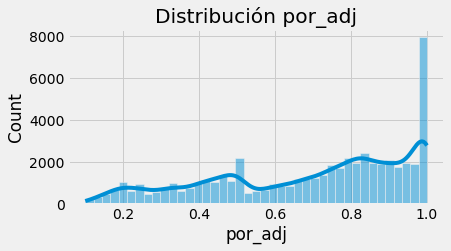

In [66]:
# Distribución variable respuesta
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(data=datos, x='por_adj', kde=True,ax=ax)
ax.set_title("Distribución por_adj")
ax.set_xlabel('por_adj');

plt.savefig("distribucion_por_adj.png")


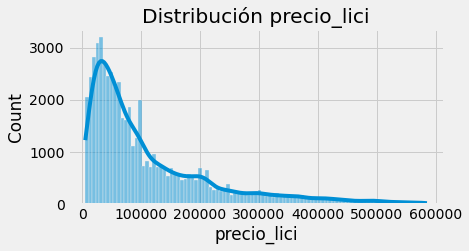

In [67]:
# Gráfico de distribución para la variable numérica
# ==============================================================================
ig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(data=datos, x='precio_lici', kde=True,ax=ax)
ax.set_title("Distribución precio_lici")
ax.set_xlabel('precio_lici');

plt.savefig("Distribucion_preci_lici.png")


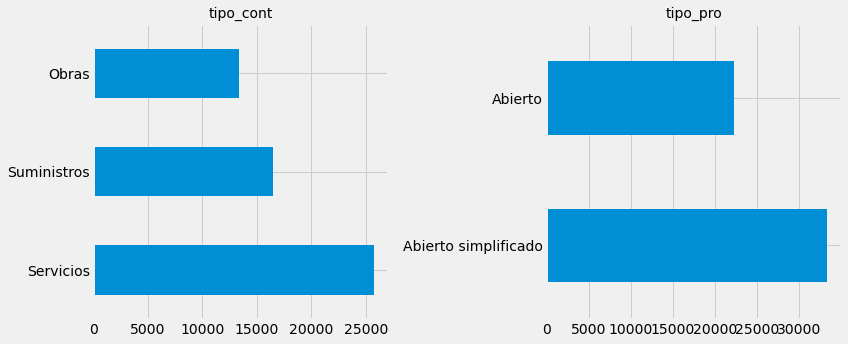

In [68]:
# Variables cualitativas (tipo object)
# ==============================================================================
datos.select_dtypes(include=['object']).describe()


# Gráfico para cada variable cualitativa
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flat
columnas_object = datos.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    datos[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 14)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
#for i in [7, 8]:
    #fig.delaxes(axes[i])
    
fig.tight_layout()

plt.savefig("Variables_categoricas.png")

In [69]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('por_adj', axis = 'columns'),
                                        datos['por_adj'],
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle      = True
                                    )

In [70]:
# Pipeline de preprocedado y modelado
# ==============================================================================

# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', MLPRegressor(solver = 'lbfgs', max_iter= 1000))])

In [71]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'modelo__hidden_layer_sizes': [(10), (20),(10, 1), (100)],
    'modelo__alpha': np.logspace(-3, 3, 10),
    'modelo__learning_rate_init': [0.001, 0.01],
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 100,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

,param_modelo__learning_rate_init,param_modelo__hidden_layer_sizes,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
47,0.01,100,2.154435,-0.049862,0.000700,-0.049797,0.000161
18,0.001,20,0.021544,-0.049863,0.000655,-0.049817,0.000206
38,0.001,100,0.464159,-0.049863,0.000675,-0.049796,0.000187
7,0.01,100,0.001,-0.049864,0.000693,-0.049783,0.000165
31,0.01,100,0.1,-0.049866,0.000689,-0.049808,0.000174
22,0.001,100,0.021544,-0.049868,0.000702,-0.049806,0.000150
6,0.001,100,0.001,-0.049868,0.000689,-0.049806,0.000180
39,0.01,100,0.464159,-0.049868,0.000689,-0.049805,0.000171
14,0.001,100,0.004642,-0.049869,0.000669,-0.049806,0.000201
30,0.001,100,0.1,-0.049869,0.000700,-0.049799,0.000161


In [72]:
# Error de test
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
print('Error de test (rmse): ', rmse)

Error de test (rmse):  0.22554769715630546


In [73]:
modelo_final['modelo'].get_params()

{'activation': 'relu',
 'alpha': 2.154434690031882,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 100,
 'learning_rate': 'constant',
 'learning_rate_init': 0.01,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

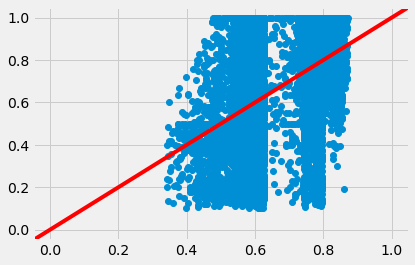

In [74]:
fig, ax = plt.subplots()
plt.plot(predicciones, y_test,'o')
plt.axline((0,0),(1,1),color='red');

In [75]:
plt.savefig("PrediccionVSReal.png")

<Figure size 432x288 with 0 Axes>